In [2]:
cd ..

/home/dmitrii/thesis


In [33]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import json
from sklearn.model_selection import GroupKFold
import albumentations as A
import cv2
import torch

from models.adv_unet_train_val_early import Model as model_adv
from models.adv_unet_train_val_late import Model as model_late
from models.unet import Model as model_baseline
from models.unet_pre_trained_contrastive import Model as model_contrastive
from models.unet_pre_trained_rotation import Model as model_rotation
from models.unet_pre_trained_patch import Model as model_patch

from experiments.baseline.data_generator import Preprocessing

# Format Data

In [34]:
model_baseline_2 = model_baseline.restore(model_name='./data/model_weights/unet_2_baseline_ACDC/unet_2_baseline_ACDC_2_split_table_fold_0.66_0.7_1616297473.405544'
                              ,gpu=None,inference=True)


model_adv_early_2 = model_adv.restore(model_name='./data/model_weights/unet_2_adversarial_ACDC_early/unet_2_adversarial_ACDC_early_2_split_table_fold_0.7_0.75_1616355233.7193034'
                              ,gpu=None,inference=True)

model_rotation_2 = model_rotation.restore(model_name='./data/model_weights/unet_2_pretrained_rotation_ACDC/unet_2_pretrained_rotation_ACDC_2_split_table_fold_0.8_0.74_1616525728.295259'
                              ,gpu=None,inference=True)

model_patch_2 = model_patch.restore(model_name='./data/model_weights/unet_2_pretrained_patch_ACDC//unet_2_pretrained_patch_ACDC_2_split_table_fold_0.79_0.74_1616787264.248821'
                              ,gpu=None,inference=True)


model_contrastive_2 = model_contrastive.restore(model_name='./data/model_weights/unet_2_pretrained_contrastive_ACDC/unet_2_pretrained_contrastive_ACDC_2_split_table_fold_0.77_0.72_1616621866.9812696'
                              ,gpu=None,inference=True)


model_baseline_UB = model_baseline.restore(model_name='./data/model_weights/unet_UB_baseline_ACDC/unet_UB_baseline_ACDC_UB_split_table_fold_0.92_0.9_1616380360.3095787'
                              ,gpu=None,inference=True)

preproc = Preprocessing(aug=False, dataset='ACDC_8')

Cuda available:  True
Cuda available:  True
Cuda available:  True
Cuda available:  True
Cuda available:  True
Cuda available:  True


In [ ]:
model_baseline_8 = model_baseline.restore(model_name='./data/model_weights/unet_8_baseline_ACDC/unet_8_baseline_ACDC_8_split_table_fold_0.83_0.83_1616377667.68225'
                              ,gpu=None,inference=True)

model_adv_early_8 = model_adv.restore(model_name='./data/model_weights/unet_8_adversarial_ACDC_early/unet_8_adversarial_ACDC_early_8_split_table_fold_0.83_0.82_1616389845.9917405'
                              ,gpu=None,inference=True)

In [112]:
DATA_PATH =  './data/ACDC_dataset/processed_data/'
patient_list = [DATA_PATH+i for i in os.listdir(DATA_PATH) if i.find('cfg')==-1]

def predict(image,model):
    image,_ = preproc.run(image,y=[0])
    image = torch.unsqueeze(torch.tensor(image),dim=0)

    pred = model.model(image)
    pred = torch.squeeze(pred,dim=0)
    pred = pred.detach().numpy()
    image = image.detach().numpy()
    pred = np.argmax(pred,axis=0)

    return pred

In [118]:
image = patient_list[50]+'/10_voxels.npy'

labels = np.load(image[:-10] + 'labels.npy')
image = np.load(image)

In [119]:
baseline_pred = predict(image,model_baseline_2)
adv_early_pred = predict(image,model_adv_early_2)
rotation_pred = predict(image,model_rotation_2)
patch_pred = predict(image,model_patch_2)
contrastive_pred = predict(image,model_contrastive_2)
UB_pred = predict(image,model_baseline_UB)


In [123]:
image

array([[[ 24,  40,  65, ...,  19,  18,  18],
        [ 44,  65,  73, ...,  19,  19,  19],
        [ 65,  66,  45, ...,  20,  19,  20],
        ...,
        [100,  70,  58, ...,  34,  32,  30],
        [ 89,  83,  85, ...,  42,  42,  38],
        [104, 104, 104, ...,  43,  44,  42]]], dtype=int16)

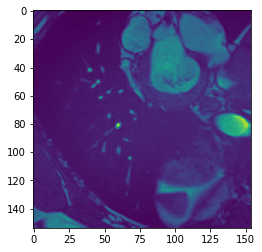

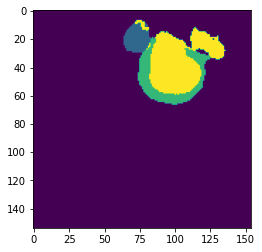

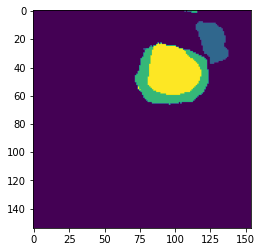

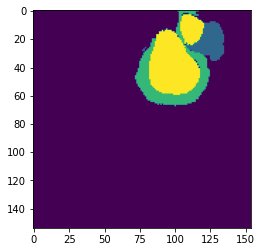

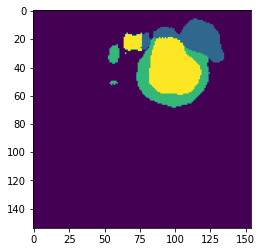

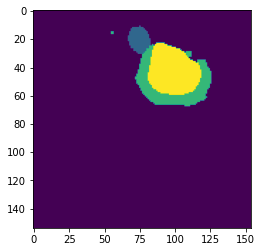

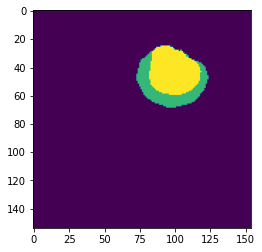

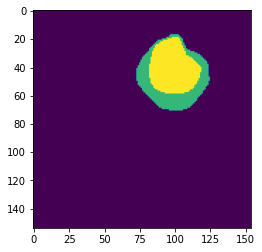

In [121]:
fig = plt.figure()
plt.imshow(image[0])

fig = plt.figure()
plt.imshow(baseline_pred)

fig = plt.figure()
plt.imshow(adv_early_pred)

fig = plt.figure()
plt.imshow(rotation_pred)

fig = plt.figure()
plt.imshow(patch_pred)

fig = plt.figure()
plt.imshow(contrastive_pred)

fig = plt.figure()
plt.imshow(UB_pred)

fig = plt.figure()
plt.imshow(labels[0])

In [78]:
np.unique(labels)

array([0], dtype=uint8)

In [15]:
patient_list

['./data/ACDC_dataset/processed_data/.ipynb_checkpoints',
 './data/ACDC_dataset/processed_data/patient001',
 './data/ACDC_dataset/processed_data/patient002',
 './data/ACDC_dataset/processed_data/patient003',
 './data/ACDC_dataset/processed_data/patient004',
 './data/ACDC_dataset/processed_data/patient005',
 './data/ACDC_dataset/processed_data/patient006',
 './data/ACDC_dataset/processed_data/patient007',
 './data/ACDC_dataset/processed_data/patient008',
 './data/ACDC_dataset/processed_data/patient009',
 './data/ACDC_dataset/processed_data/patient010',
 './data/ACDC_dataset/processed_data/patient011',
 './data/ACDC_dataset/processed_data/patient012',
 './data/ACDC_dataset/processed_data/patient013',
 './data/ACDC_dataset/processed_data/patient014',
 './data/ACDC_dataset/processed_data/patient015',
 './data/ACDC_dataset/processed_data/patient016',
 './data/ACDC_dataset/processed_data/patient017',
 './data/ACDC_dataset/processed_data/patient018',
 './data/ACDC_dataset/processed_data/patie

In [79]:
for patient in tqdm(patient_list):
    
    files = [i for i in os.listdir(DATA_PATH+patient+'/') if i.find('frame')!=-1 and i.find('gt')==-1]
    
    for index,file in enumerate(files):
        if index == 0:
            img = np.array(nib.load(DATA_PATH+patient+'/'+file).dataobj)
            seg = np.array(nib.load(DATA_PATH+patient+'/'+file[:-7]+'_gt.nii.gz').dataobj)
            
        else:
            temp_img = np.array(nib.load(DATA_PATH+patient+'/'+file).dataobj)
            temp_seg = np.array(nib.load(DATA_PATH+patient+'/'+file[:-7]+'_gt.nii.gz').dataobj)
            img = np.concatenate([img,temp_img],axis=2)
            seg = np.concatenate([seg,temp_seg],axis=2)
    

        
    
    if img.shape[0] > 154:
        x_cut = (img.shape[0]-154)//2
        img = img[x_cut:-1*x_cut,:,:]
        seg = seg[x_cut:-1*x_cut,:,:]
        
    if img.shape[1] > 154:
        y_cut = (img.shape[1]-154)//2
        img = img[:,y_cut:-1*y_cut,:]
        seg = seg[:,y_cut:-1*y_cut,:]
    
    
    img = np.expand_dims(img,axis=0)                  
    seg = np.expand_dims(seg,axis=0)  
    
    
    
    os.makedirs(OUT_PATH+patient,exist_ok=True)
    
 
    
    for i in range(img.shape[-1]):
        temp = img[:,:,:,i]
        temp_y = seg[:,:,:,i]

        
        #save
        np.save(OUT_PATH+patient+f'/{i}_voxels.npy',temp)
        np.save(OUT_PATH+patient+f'/{i}_labels.npy',temp_y)
    


100%|██████████| 100/100 [00:29<00:00,  3.43it/s]


In [179]:
def select_patch(X, sector):
    # optional: upsample if too much

    X = np.transpose(X.astype(np.float32), (1, 2, 0))

    X = cv2.resize(X, (X.shape[0] * 3, X.shape[1] * 3))

    if len(X.shape) < 3:
        X = np.expand_dims(X, axis=2)

    split_x = X.shape[0] // 3
    split_y = X.shape[1] // 3

    overlap = split_x//4


    if sector == 0:
        X2 = X[0:split_x+overlap*2, 0:split_y+overlap*2, :]
    elif sector == 1:
        X2 = X[split_x-overlap:split_x * 2+overlap, 0:split_y+overlap*2, :]
    elif sector == 2:
        X2 = X[split_x * 2-overlap*2:split_x * 3, 0:split_y+overlap*2, :]
    elif sector == 3:
        X2 = X[split_x * 2-overlap*2:split_x * 3, split_y-overlap:split_y * 2+overlap, :]
    elif sector == 4:
        X2 = X[split_x * 2-overlap*2:split_x * 3, split_y * 2-overlap*2:split_y * 3, :]
    elif sector == 5:
        X2 = X[split_x-overlap:split_x * 2+overlap, split_y * 2-overlap*2:split_y * 3, :]
    elif sector == 6:
        X2 = X[0:split_x+overlap*2, split_y * 2-overlap*2:split_y * 3, :]
    elif sector == 7:
        X2 = X[0:split_x+overlap*2, split_y-overlap:split_y * 2+overlap, :]
    elif sector == 8:
        X2 = X[split_x-overlap:split_x * 2+overlap, split_y-overlap:split_y * 2+overlap, :]


    X2 = np.transpose(X2.astype(np.float32), (2, 0, 1))

    return X2

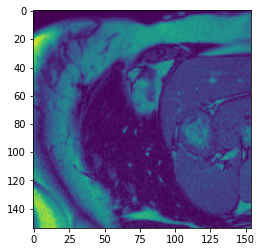

In [187]:
a1 = select_patch(temp,6)
a2 = select_patch(temp,7)
plt.imshow(temp[0])


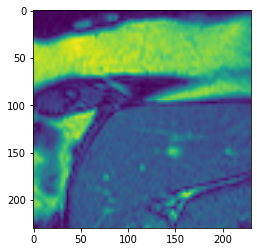

In [188]:
plt.imshow(a1[0])

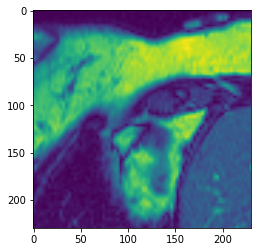

In [189]:
plt.imshow(a2[0])

In [178]:
print(a1.shape)
print(a2.shape)

(1, 230, 230)
(1, 230, 230)


# Prepare split tables

In [190]:
patient_list = [OUT_PATH[1:]+i for i in os.listdir(OUT_PATH) if i.find('.')==-1]
print(f'Total number of patients: {len(patient_list)}')

Total number of patients: 100


In [191]:
patient_arr = []
records = []
for patient in patient_list:
    records += [patient+'/'+i for i in os.listdir('.'+patient) if i.find('voxels')!=-1]
    patient_arr += [patient]*len([patient+'/'+i for i in os.listdir('.'+patient) if i.find('voxels')!=-1])
    
records = np.array(records)
patient_arr = np.array(patient_arr)

In [173]:
#create test
kf = GroupKFold(n_splits=5)

for (train,test) in kf.split(records,records,patient_arr):
    
    records_test = records[test]
    
    
    #create test
    split = {
            'test': records_test.tolist(),
        }
    
    with open(f'{TABLE_PATH}test_split_table.json', 'w') as outfile:
            json.dump(split, outfile)
    break

patient_arr = patient_arr[train]
records = records[train]

In [174]:
#create train and validation
n_patients = [2,4,8]

patients_unique = np.unique(patient_arr)

for i in n_patients:
    
    train_patients = patients_unique[:i]
    train_records = np.empty(0)
    for patient in train_patients.tolist():
        train_records = np.append(train_records,records[patient_arr==patient],axis=0)
    
    val_patients = patients_unique[-2:]
    val_records = np.empty(0)
    for patient in val_patients.tolist():
        val_records = np.append(val_records,records[patient_arr==patient],axis=0)
    
    
    
    split = {
            'train': train_records.tolist(),
            'val': val_records.tolist(),
            'pretrain': records.tolist(),
        }
    with open(f'{TABLE_PATH}{i}_split_table.json', 'w') as outfile:
            json.dump(split, outfile)


In [175]:
#create UB

train_patients = patients_unique[patients_unique.shape[0]//5:]
train_records = np.empty(0)
for patient in train_patients.tolist():
    train_records = np.append(train_records,records[patient_arr==patient],axis=0)

val_patients = patients_unique[:patients_unique.shape[0]//5]
val_records = np.empty(0)
for patient in val_patients.tolist():
    val_records = np.append(val_records,records[patient_arr==patient],axis=0)

split = {
        'train': train_records.tolist(),
        'val': val_records.tolist(),
        }
with open(f'{TABLE_PATH}UB_split_table.json', 'w') as outfile:
            json.dump(split, outfile)


# Review augs

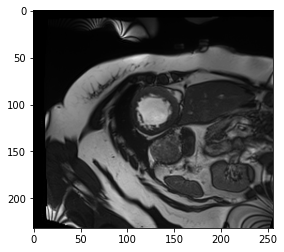

In [148]:
prob = 1
augs = A.Compose(
                [ 
                    A.HorizontalFlip(p=prob),
                    A.VerticalFlip(p=prob),
                    A.Rotate(limit=170, p=prob),
                    A.ElasticTransform(alpha=0.1,p=prob),
                    A.RandomSizedCrop(min_max_height=(120, 120), height=300, width=300, p=prob),
                    A.RandomGamma(gamma_limit=(80, 120), p=prob)
                ]
            )
temp = np.transpose(temp.astype(np.float32), (1, 2, 0))
augmented = augs(image=temp)
temp = np.transpose(temp.astype(np.float32), (2, 0, 1))
image = augmented['image']
image = np.transpose(image.astype(np.float32), (2, 0, 1))

plt.imshow(temp[0],'gray')

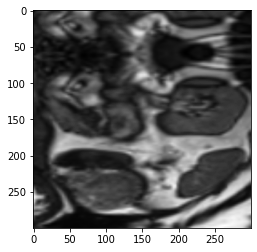

In [149]:
plt.imshow(image[0],'gray')

In [23]:
import numpy as np
import cv2

def rotate_image(image, angle):
    image = np.transpose(image.astype(np.float32), (1, 2, 0))
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    result = np.transpose(result.astype(np.float32), (2, 0, 1))
    return result

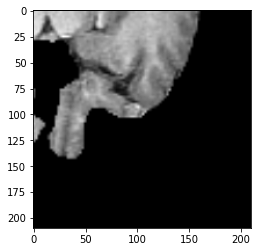

In [24]:
y = rotate_image(image,90)
plt.imshow(y[2],'gray')